I need to plot the clustering to do verifications
Wrap silhouette around kmeans to get proper numk
Also I should put in check boxes that cluster on popularity, change, and consistency
  popularity:  avg, max, and difference from threshold
  change:  diff of 1st and last, avg(diff()), diff of max and min
  consistency: rms, rms(diff), max(diff), min(diff)

In [157]:
import requests
import pandas as pd
from pandas import read_sql
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pymysql as mdb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [158]:
np.argmax([5,2,7,4,1])

2

In [159]:
def datetime2str(t):
    return "%4d%02d%02d%02d"%(t.year,t.month,t.day,t.hour)

def datetime2str(t):
    return "%4d%02d%02d"%(t.year,t.month,t.day,)
    
def gen_feat(into):
    avg=np.average(into)
    if avg==0: avg=1
    chfl=-(into[0]-into[len(into)-1])/avg
    avgdiff=np.average(np.diff(into))/avg
    diffmm=np.sign(np.argmax(into)-np.argmin(into))*(max(into)-min(into))/avg
    maxv= np.max(into)/avg
    minv= np.min(into)
    rmsv= np.std(into)
    difxv=np.max(np.diff(into))
    difnv=np.min(np.diff(into))
    pop=[avg,maxv]
    change=[chfl,avgdiff,diffmm]
    change=[chfl,diffmm]
    consis=[rmsv/avg,np.std(np.diff(into))]#,np.max(np.diff(into))]
    return([avg,diffmm])#,minv,rmsv,difxv,difnv])

In [198]:
feat=True
dateinput=datetime.datetime(2015,9,15,16)
searchtopic=45
numk=6
def get_selected(searchtopic, dateinput,numk,feat):
    numtopics=84
    
    afile="/Users/abramvandergeest/mysql_insightwiki_auth.txt"
    a=open(afile)
    passwd=a.readline().rstrip()
    a.close()
    host='localhost'; user='abram.ghost';db='wikidata'
    con = mdb.connect(host, user, passwd, db,port=3307)
    
    with con:
        curt= con.cursor()
        #sql="SELECT COUNT(*) FROM `topics` "
        
        sql="SELECT `Id`,`topic_label`,`topic_string` FROM `topics`;"
        curt.execute(sql)
        topics=[[0,'nothing','Filler to match index']]
        for topic in curt:
            topics.append(topic)
    
    data={}
        
    df=range(numtopics+1)
    with con:
        curt= con.cursor()
        sql="SELECT `Id`,`topic_label`,`topic_string` FROM `topics`;"
        curt.execute(sql)
        for row in curt:
            cur = con.cursor()
            sql='''SELECT AVG(`page_views`.`count`) AS `vc`,`page_views`.`dateonly` AS `vd` 
                 FROM `topics` INNER JOIN `page_views` on `topics`.`ID` = `page_views`.`topic_id` 
                 WHERE `topics`.`id`=%s GROUP BY `page_views`.`dateonly` '''
            sql='''SELECT `page_views`.`dateonly` AS `vd`, AVG(`page_views`.`count`) AS `vc`, 
                `topics`.`topic_label`,`topics`.`topic_string` 
                FROM `topics` INNER JOIN `page_views` ON `topics`.`ID` = `page_views`.`topic_id` 
                WHERE `topic_id`=%s GROUP BY `page_views`.`dateonly`   '''
            data[row[1]]=read_sql(sql, con,params=[row[0]])
            df[row[0]]=data[row[1]]
    
    topicdata=df
    
    #setting dates to take slice of data with
    datefin=dateinput+datetime.timedelta(days=7)
    di=datetime2str(dateinput)
    dfin=datetime2str(datefin)
    topicdata=df
    
    #initializing array to hold the rows to cluster
    #the 0th position is fake so that my index matches the sql index
    clusinp=[]
    if feat==True:
        clusinp.append(gen_feat([0,0,0,0,0]))
    else:
        clusinp.append([0,0,0,0])
  
    #populating my array to go into my Kmean
    for index,topic in enumerate(topics):
        #topic=list(topics[index])
        if topic[0]!=0:
            d=topicdata[topic[0]]
            #print d[ (d['vd']>di) & (d['vd']<dfin )]['vd'].values
            
            if feat==True: #use the slope/variation features
                p=gen_feat(d[ (d['vd']>di) & (d['vd']<dfin )]['vc'].values)
            else:  # just use the direct view counts
                p=d[ (d['vd']>di) & (d['vd']<dfin )]['vc'].values
            #print len(p),type(p),p
            clusinp.append(p)
    
    #cleaning up my array making it numpy to go into my kmean
    clusinp=np.array(clusinp)
    clusinp[0]=clusinp[5] #making sure my through away first row matches in size
        
    #print clusinp
    #for i,l in enumerate(clusinp):
    #    print i,len(l),type(l), l
    #print type(clusinp), len(clusinp[0]),len(clusinp[45])
    
    #use Kmeans to find clustering for numk clusters
    kmeans=KMeans(n_clusters=numk,n_init=30,max_iter=500,init='random')
    kmeans.fit(clusinp)
    labels=kmeans.labels_
        
    #gathering the topics by cluster label
    topinclus=[[] for i in xrange(numk)]
    for index,cluster in enumerate(labels):
        topinclus[cluster].append(topics[index][0])
    
    #gathering the topics of the same cluster as the selected topic together
    for index,k in enumerate(topinclus):
        for t in k:
            if t==searchtopic:
                gsearch=index

    #Making a list of the topics in this group     
    simtopic=[]
    for i in topinclus[gsearch]:
        simtopic.append(topics[i])
    
    #getting the average view for the chosen topic for the day
    dinp=dateinput
    di=datetime2str2(datetime.datetime(dinp.year,dinp.month,dinp.day,0))
    dfin=datetime2str2(datetime.datetime(dinp.year,dinp.month,dinp.day,23))
    d=df[searchtopic]
    pc=int(np.round(np.average(d[ (d['vd']>=di) & (d['vd']<=dfin )]['vc'].values)))
     
    return [simtopic ,pc]

In [199]:
out=get_selected(searchtopic, dateinput,numk,feat)
print out[1]
print out[0]

1132
[[0, 'nothing', 'Filler to match index'], (5, 'berniesanders', 'Bernie Sanders'), (7, 'jebbush', 'Jeb Bush'), (9, 'chrischristie', 'Chris Christie'), (45, 'islamicstate', 'islamic state'), (50, 'northkorea', 'north korea'), (57, 'immigration', 'immigration'), (71, 'plannedparenthood', 'Planned Parenthood'), (79, 'nasa', 'NASA')]


In [195]:
feat=True
dateinput=datetime.datetime(2015,9,15,16)
searchtopic=45
numk=6
#def get_selected(searchtopic, dateinput,numk,feat):
numtopics=84
    
afile="/Users/abramvandergeest/mysql_insightwiki_auth.txt"
a=open(afile)
passwd=a.readline().rstrip()
a.close()
host='localhost'; user='abram.ghost';db='wikidata'
con = mdb.connect(host, user, passwd, db,port=3307)
    
with con:
        curt= con.cursor()
        #sql="SELECT COUNT(*) FROM `topics` "
        
        sql="SELECT `Id`,`topic_label`,`topic_string` FROM `topics`;"
        curt.execute(sql)
        topics=[[0,'nothing','Filler to match index']]
        for topic in curt:
            topics.append(topic)
    
data={}
        
df=range(numtopics+1)
with con:
        curt= con.cursor()
        sql="SELECT `Id`,`topic_label`,`topic_string` FROM `topics`;"
        curt.execute(sql)
        for row in curt:
            cur = con.cursor()
            #sql='''SELECT AVG(`page_views`.`count`) AS `vc`,`page_views`.`dateonly` AS `vd` 
            #     FROM `topics` INNER JOIN `page_views` on `topics`.`ID` = `page_views`.`topic_id` 
            #     WHERE `topics`.`id`=%s GROUP BY `page_views`.`dateonly` '''
            sql='''SELECT `page_views`.`dateonly` AS `vd`, AVG(`page_views`.`count`) AS `vc`, 
                `topics`.`topic_label`,`topics`.`topic_string` 
                FROM `topics` INNER JOIN `page_views` ON `topics`.`ID` = `page_views`.`topic_id` 
                WHERE `topic_id`=%s GROUP BY `page_views`.`dateonly`   '''
            data[row[1]]=read_sql(sql, con,params=[row[0]])
            df[row[0]]=data[row[1]]
    
topicdata=df
    
#setting dates to take slice of data with
datefin=dateinput+datetime.timedelta(days=7)
di=datetime2str(dateinput)
dfin=datetime2str(datefin)
topicdata=df
    
#initializing array to hold the rows to cluster
#the 0th position is fake so that my index matches the sql index
clusinp=[]
if feat==True:
    clusinp.append(gen_feat([0,0,0,0,0]))
else:
    clusinp.append([0,0,0,0])
    
#populating my array to go into my Kmean
for index,topic in enumerate(topics):
        #topic=list(topics[index])
        if topic[0]!=0:
            d=topicdata[topic[0]]
            #print d[ (d['vd']>di) & (d['vd']<dfin )]['vd'].values
            
            if feat==True: #use the slope/variation features
                p=gen_feat(d[ (d['vd']>di) & (d['vd']<dfin )]['vc'].values)
            else:  # just use the direct view counts
                p=d[ (d['vd']>di) & (d['vd']<dfin )]['vc'].values
            #print len(p),type(p),p
            clusinp.append(p)
    
#cleaning up my array making it numpy to go into my kmean
clusinp=np.array(clusinp)
clusinp[0]=clusinp[5] #making sure my through away first row matches in size
        
##using silhouette_score and kmeans to find the bast cluster for k>2
sil=[]
silmin=3
silit=0.85
for numk in xrange(silmin,10):
    #use Kmeans to find clustering for numk clusters
    kmeans=KMeans(n_clusters=numk,n_init=30,max_iter=500,init='random')
    kmeans.fit(clusinp)
    labels=kmeans.labels_

    silhouette_avg = silhouette_score(clusinp, labels)
    #print("For n_clusters =", numk,
    #      "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg-silit>-0.01:
        #print numk
        break
    silit=silhouette_avg


#gathering the topics by cluster label
topinclus=[[] for i in xrange(numk)]
for index,cluster in enumerate(labels):
        topinclus[cluster].append(topics[index][0])
    
#gathering the topics of the same cluster as the selected topic together
for index,k in enumerate(topinclus):
        for t in k:
            if t==searchtopic:
                gsearch=index

#Making a list of the topics in this group     
simtopic=[]
for i in topinclus[gsearch] :
    if topics[i][0]!=0:
        simtopic.append(topics[i])
        #print topics[i][0]
    
#getting the average view for the chosen topic for the day
dinp=dateinput
di=datetime2str2(datetime.datetime(dinp.year,dinp.month,dinp.day,0))
dfin=datetime2str2(datetime.datetime(dinp.year,dinp.month,dinp.day,23))
d=df[searchtopic]
pc=int(np.round(np.average(d[ (d['vd']>=di) & (d['vd']<=dfin )]['vc'].values)))
     
#    return [simtopic ,pc]



45
2015-09-15 16:00:00
[(5, 'berniesanders', 'Bernie Sanders'), (8, 'bencarson', 'Ben Carson'), (9, 'chrischristie', 'Chris Christie'), (28, 'immigra', 'Immigra'), (45, 'islamicstate', 'islamic state'), (57, 'immigration', 'immigration'), (71, 'plannedparenthood', 'Planned Parenthood')] 1132


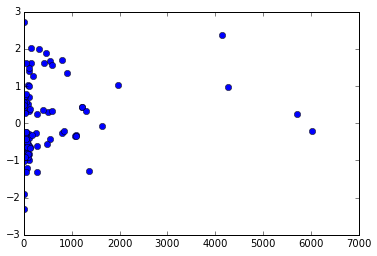

In [197]:
print searchtopic
print dateinput
print simtopic ,pc

npclusin=np.array(clusinp)
%matplotlib inline
plt.plot(npclusin[:,0],npclusin[:,1],'o')
plt.show()